In [296]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [297]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [298]:
len(words)

32033

In [299]:
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
print(itoc)
vocab_size = len(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [300]:
# build the dataset

block_size = 3 # context length; how many characters do we need to predict the next one?
X,Y = [], []

for w in words:
    context = [0]* block_size
    for ch in w + '.':
        index = ctoi[ch]
        X.append(context)
        Y.append(index)
        #print(''.join(itoc[i] for i in context), '----->', itoc[index])
        context = context[1:] + [index] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [307]:
def build_dataset(words):
    block_size = 3 # context length; how many characters do we need to predict the next one?
    X,Y = [], []
    
    for w in words:
        context = [0]* block_size
        for ch in w + '.':
            index = ctoi[ch]
            X.append(context)
            Y.append(index)
            #print(''.join(itoc[i] for i in context), '----->', itoc[index])
            context = context[1:] + [index] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
ix1 = math.floor(0.8*len(words))
ix2 = math.floor(0.9*len(words))
Xtr, Ytr = build_dataset(words[:ix1])
Xdev, Ydev = build_dataset(words[ix1:ix2])
Xte, Yte = build_dataset(words[ix2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [308]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182437, 3]), torch.int64, torch.Size([182437]), torch.int64)

In [309]:
# making it more respectable

In [310]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [306]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb), generator=g) # ten-dimensional embeddings
W1 = torch.randn((block_size*n_emb,n_hidden), generator=g) * (5/3) * (1/(block_size*n_emb)**0.5) * 0 # kaiming init
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0 # a better initialization; smaller weights give less extreme logits
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) # trainable std parameter
bnbias = torch.zeros((1, n_hidden)) # trainable mean parameter
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
lre = torch.linspace(-1,-2,10000) # log values of the learning rates, which are linearly spaced
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
# we want to convert the embedding tensor of shape (number of samples, block_size, size of embedding) to 
# a shape of (number of samples, block_size*size_of_embedding) which we then multiply with the weight matrix W1

In [ ]:
x = torch.randn(1000, 1) # just an example
w = torch.randn(1, 200) #/ ((5/3)*(10**0.5))# kaiming init; makes sure that the product also has unit standard deviation
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.Figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
max_steps = 200000
batch_size = 64

for i in range(200000):
    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (64,)) # generating 64 random indices for the minibatch
    
    # forward pass
    emb = C[Xtr[ix]] 
    embcat = emb.view(-1,block_size*n_emb)
    # linear layer
    hpreact = embcat @ W1 #+ b1 # the tanh activations become saturated if abs(hpreact) takes on values > 2.64 
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization
    with torch.no_grad(): # calculating the running mean and std which is an estimate of the actual mean/std over the entire training set
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    # Non-Linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i < 50000:
        lr = 0.1
    elif i < 150000:
        lr = 0.05
    else:
        lr = 0.01
        
    
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    #break; intended to check whether tanh neurons were saturated right at the start of training.
#print(loss.item())

In [ ]:
logits[0] # much smaller since we scaled W2 down

In [ ]:
h 

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
plt.hist(h.view(-1).tolist(), 50); # 

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # initially very broad; take values from -15 to 15; when we scale down W1, its much more peaky

The loss wobbles around in the above example since the gradient we used is just an approximation; it's not the actual gradient. But still, the loss goes down over many iterations. 

In [ ]:
plt.plot(stepi, lossi) # this plot is used to find a good learning rate; note that x axis has log values of the lrs; the *exponents* of 10

In [ ]:
# calibrate the batch norm at the end of training explicitly

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat@ W1 + b1
    # measure the mean and std over the entire traning set, instead of just a single batch
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [ ]:
bnmean # from the explicit calculation

In [ ]:
bnmean_running # hopefully this is close enough to the explicit calculation of bnmean

In [ ]:
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # indexing into a dictionary


    emb = C[x] 
    embcat = emb.view(-1, block_size*n_emb)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias # normalizing over the entire training/validation set; each example is coupled with the entire training set
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(f"{split} {loss.item()}")
    
split_loss('train')
split_loss('val')

In [ ]:
b2.grad

In [ ]:
# loss log

# original: train: 2.12, val: 2.16
# after fixing softmax being confidently wrong (by reducing the size of logits by scaling down W2): train-> 2.07, val->2.13
# fixing tanh being too satuarted at intialization (by scaling down W1 and b1): train-> 2.02, val-> 2.10
# adding a batch norm layer: train 2.0441455841064453 val 2.0975942611694336

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch. Generator().manual_seed (2147483647 + 10)
for _ in range (20) :
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 + b1
        #print(hpreact.shape)
        hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
        #print(hpreact)
        h = torch.tanh(hpreact) 
        logits = h @ W2 + b2 
        #probs = torch.ones((1, 27)) * (1/27) # each character has a uniform probability
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs[0], num_samples=1, generator=g). item()
        context = context[1:] + [ix]
        out.append(ix)   
        if ix == 0: break
    print(''.join(itoc[i] for i in out))

In [347]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 
        self.bias = torch.zeros(fan_out) if bias else None # don't play any role; compensated by beta in BatchNorm

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained by backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained by a running 'momentum' update, not via backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else: # if we're doing inference
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # BatchNorm to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training: 
            with torch.no_grad(): # since we're not going to need the gradient of these two buffers
                self.running_mean = (1-self.momentum)* self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)* self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # size of the hidden layer
g = torch.Generator().manual_seed(2147483647)

# initializing the parameters
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

# with torch.no_grad(): # just initialization; not actually updating the weights via SGD
#     layers[-1].gamma *= 0.1 # last layer => make softmax less confident
#     layers[-1].beta *= 0.1
#     # all the other layers -> apply kaimit gain
#     for layer in layers:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
#p2 = [C] + [layer.parameters() for layer in layers] # this a list of lists of parameters, not a list of parameters; that's why needed the double comprehension to unpack
for p in parameters:
    p.requires_grad = True

47351


In [348]:
# same optimization as last time

max_steps = 20000
num_samples = 64
lossi = []
ud = []

for i in range(max_steps):
    # construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (num_samples, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # mini batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(Xb.shape[0], -1) # = embcat
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i < 50000:
        lr = 1.0
    elif i < 150000:
        lr = 0.05
    else:
        lr = 0.01 

    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # adding the update:data ratio for each of the layers' parameters 
        
    if i>1000:
         break

    

      0/  20000: 3.7781


In [352]:
def split_loss(split):
    X,Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # indexing into a dictionary


    # forward pass
    emb = C[X] # embed the characters into vectors
    x = emb.view(X.shape[0], -1) # = embcat
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(f"{split} {loss.item()}")
    
split_loss('train')
split_loss('val')

train 2.3013699054718018
val 2.319472551345825


In [353]:
print(layers[3].out.grad)

None


/var/folders/n4/wy0c3pt140qc9nsgq3n4zbcc0000gn/T/ipykernel_41904/4292353474.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(layers[3].out.grad)


layer 1 (Tanh): mean -0.06, std 0.75, saturated: 17.54%
layer 4 (Tanh): mean 0.00, std 0.67, saturated: 4.10%
layer 7 (Tanh): mean 0.00, std 0.68, saturated: 2.76%
layer 10 (Tanh): mean 0.01, std 0.68, saturated: 2.28%
layer 13 (Tanh): mean 0.00, std 0.68, saturated: 1.46%


Text(0.5, 1.0, 'Activation Distribution')

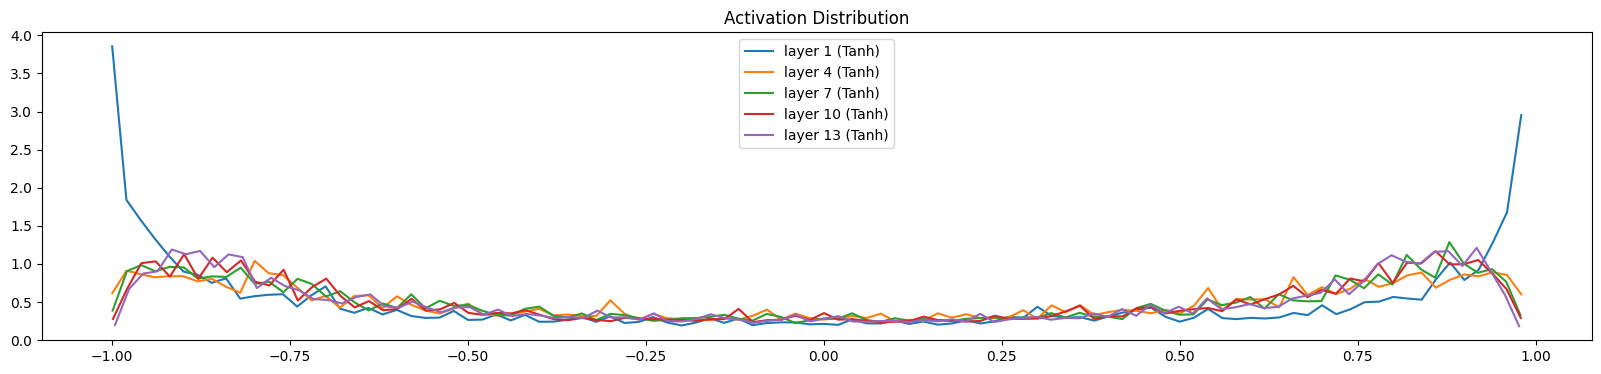

In [351]:
#visualize histograms
plt.figure(figsize=(20,4)) # width(x) and height(y) of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%s): mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True) # returns Y and X in that order
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Activation Distribution")

In [346]:
#visualize histograms
plt.figure(figsize=(20,4)) # width(x) and height(y) of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        #print('layer %d (%s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True) # returns Y and X in that order
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Gradient Distribution") # we want the gradients of all the layers to roughly be the same
# read the gradients from layer 4 to layer 0, since this is a backward pass

/var/folders/n4/wy0c3pt140qc9nsgq3n4zbcc0000gn/T/ipykernel_41904/3116839153.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  t = layer.out.grad


TypeError: histogram() received an invalid combination of arguments - got (NoneType, density=bool), but expected one of:
 * (Tensor input, Tensor bins, *, Tensor weight = None, bool density = False, tuple of Tensors out = None)
 * (Tensor input, int bins = 100, *, tuple of floats range = None, Tensor weight = None, bool density = False, tuple of Tensors out = None)


<Figure size 2000x400 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,4)) 
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2: # include only the weights, not the biases
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True) # returns Y and X in that order
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Weights Gradient Distribution")

In [ ]:
plt.figure(figsize=(20,4)) 
legends = []
for i, p in enumerate(parameters): 
    if p.ndim == 2: # only the weights
        plt.plot([ud[j][i] for j in range(len(ud))]) # plot of the parameters over time; by default range(len(ud)) is the x-axis of the plot
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be around 1e-3; indicated on plot
plt.legend(legends);

In [ ]:
len(ud)

In [ ]:
plt.plot([1,2], [3,3])